<div style="background-color: #e6f7ff; padding: 15px; border-radius: 10px;">
  <h2> Mars Rover Image Segmentation</h2>
  <p>
    This project focuses on <strong>image segmentation of Martian terrain</strong> using images captured by NASA's Curiosity Rover. 
    We analyze images from the <strong>NAVCAM, FHAZ, and RHAZ</strong> cameras to distinguish terrain features, segment surface patterns, 
    and visualize feature space using <strong>edge detection</strong>, <strong>texture-based descriptors</strong>, and <strong>PCA</strong>.
  </p>
  <p>
    The dataset used is the publicly available <strong>Mars Curiosity Image Dataset</strong> on Kaggle, making this project both 
    scientifically relevant and accessible.
  </p>
</div>

## Step 1: Load and Show Mars Curiosity Images

Sample sol folder: sol_3189
Camera folders inside sol_3189 : ['FHAZ', 'NAVCAM', 'RHAZ']
Number of images in 'FHAZ': 2


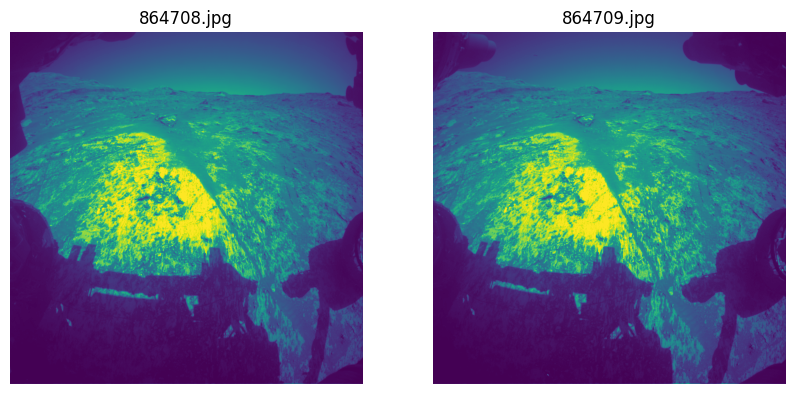

In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Base path to dataset
dataset_path = '/kaggle/input/mars-curiosity-dataset/curiosity_rich_dataset/'

# List sol folders (e.g., sol_3189, sol_3871, etc.)
sol_folders = os.listdir(dataset_path)
print("Sample sol folder:", sol_folders[0])

# Go into one sol folder (e.g., sol_3189)
sample_sol_path = os.path.join(dataset_path, sol_folders[0])

# List camera folders (e.g., FHAZ, RHAZ, NAVCAM)
camera_folders = os.listdir(sample_sol_path)
print("Camera folders inside", sol_folders[0], ":", camera_folders)

# Go into a camera folder (e.g., FHAZ)
sample_camera_path = os.path.join(sample_sol_path, camera_folders[0])
image_files = [f for f in os.listdir(sample_camera_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
print(f"Number of images in '{camera_folders[0]}':", len(image_files))

# Limit to 3 images (or fewer if not enough)
num_images = min(3, len(image_files))

# Show the images
fig, axs = plt.subplots(1, num_images, figsize=(5*num_images, 5))
if num_images == 1:
    axs = [axs]  # Make it iterable
for i in range(num_images):
    img_path = os.path.join(sample_camera_path, image_files[i])
    img = Image.open(img_path)
    axs[i].imshow(img)
    axs[i].set_title(image_files[i])
    axs[i].axis('off')
plt.show()

## Step 2: Image Segmentation using K-Means Clustering

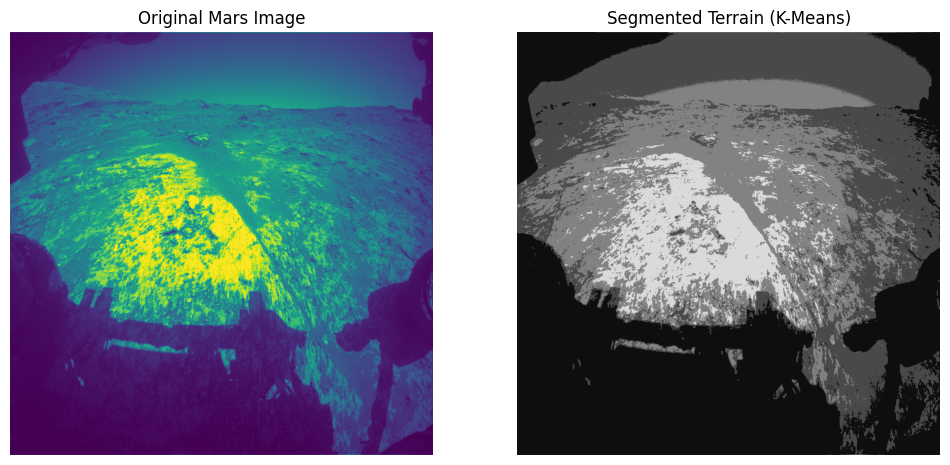

In [2]:
import cv2
import numpy as np

# Load one image (as array)
img_path = os.path.join(sample_camera_path, image_files[0])
img = Image.open(img_path)
img_np = np.array(img)

# Convert to BGR for OpenCV (if RGB)
img_cv = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

# Reshape the image to a 2D array of pixels
pixel_vals = img_cv.reshape((-1, 3))
pixel_vals = np.float32(pixel_vals)

# Define stopping criteria and number of clusters (segments)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
k = 4  # Number of terrain clusters
_, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Convert centers to uint8 and recreate segmented image
centers = np.uint8(centers)
segmented_data = centers[labels.flatten()]
segmented_image = segmented_data.reshape(img_cv.shape)

# Convert back to RGB for display
segmented_image_rgb = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB)

# Show original and segmented images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img_np)
plt.title('Original Mars Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented_image_rgb)
plt.title('Segmented Terrain (K-Means)')
plt.axis('off')
plt.show()

## Step 3: Edge Detection & Contour Extraction on Mars Terrain

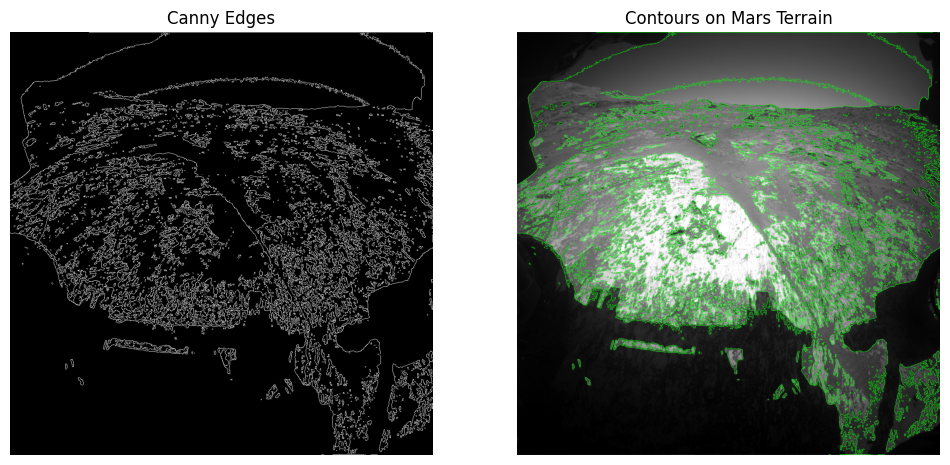

In [3]:
# Convert the segmented image to grayscale
gray = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2GRAY)

# Apply Canny Edge Detection
edges = cv2.Canny(gray, threshold1=100, threshold2=200)

# Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on a copy of the original image
contour_img = img_cv.copy()
cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 1)

# Convert contour image to RGB for display
contour_img_rgb = cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB)

# Show the result
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(edges, cmap='gray')
plt.title('Canny Edges')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(contour_img_rgb)
plt.title('Contours on Mars Terrain')
plt.axis('off')

plt.show()

## Step 4: Simple Terrain Feature Classifier (Smooth vs. Rocky)

# Step 4.1: Extract Patches & Compute Features

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import random

def extract_patch_features(image, edge_image, patch_size=32, num_patches=100):
    features = []
    labels = []

    height, width = image.shape[:2]

    for _ in range(num_patches):
        x = random.randint(0, width - patch_size)
        y = random.randint(0, height - patch_size)

        patch = image[y:y+patch_size, x:x+patch_size]
        edge_patch = edge_image[y:y+patch_size, x:x+patch_size]

        std_dev = np.std(patch)  # texture
        edge_density = np.sum(edge_patch) / (255.0 * patch_size * patch_size)

        # Heuristic: high edge density => rocky (1), else smooth (0)
        label = 1 if edge_density > 0.05 else 0

        features.append([std_dev, edge_density])
        labels.append(label)

    return np.array(features), np.array(labels)

# Extract features from patches
features, labels = extract_patch_features(img_cv, edges, patch_size=32, num_patches=200)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Step 4.2: Train & Evaluate Classifier

In [5]:
# Train logistic regression model
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Smooth", "Rocky"]))

Classification Report:
              precision    recall  f1-score   support

      Smooth       0.88      0.94      0.91        16
       Rocky       0.96      0.92      0.94        24

    accuracy                           0.93        40
   macro avg       0.92      0.93      0.92        40
weighted avg       0.93      0.93      0.93        40



## Step 5: Visualize Classified Terrain Patches on Mars Image

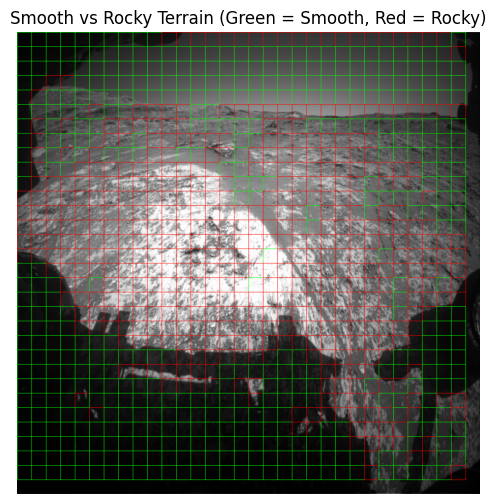

In [6]:
def visualize_patch_predictions(image, edge_image, model, patch_size=32, step=32):
    image_copy = image.copy()

    height, width = image.shape[:2]

    for y in range(0, height - patch_size, step):
        for x in range(0, width - patch_size, step):
            patch = image[y:y+patch_size, x:x+patch_size]
            edge_patch = edge_image[y:y+patch_size, x:x+patch_size]

            std_dev = np.std(patch)
            edge_density = np.sum(edge_patch) / (255.0 * patch_size * patch_size)

            pred = model.predict([[std_dev, edge_density]])[0]

            color = (0, 255, 0) if pred == 0 else (0, 0, 255)  # Green = Smooth, Red = Rocky
            cv2.rectangle(image_copy, (x, y), (x+patch_size, y+patch_size), color, 1)

    return cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)

# Run the visualization
result_image = visualize_patch_predictions(img_cv, edges, clf)

# Show it
plt.figure(figsize=(12, 6))
plt.imshow(result_image)
plt.title("Smooth vs Rocky Terrain (Green = Smooth, Red = Rocky)")
plt.axis('off')
plt.show()

## Outcome:
You’ll see your Mars terrain image with color-coded rectangles:

Green → predicted smooth area

Red → predicted rocky area

## Step 6: Count % of Rocky vs Smooth Area

In [7]:
def calculate_area_percentages(image, edge_image, model, patch_size=32, step=32):
    counts = {'smooth': 0, 'rocky': 0}
    height, width = image.shape[:2]

    for y in range(0, height - patch_size, step):
        for x in range(0, width - patch_size, step):
            patch = image[y:y+patch_size, x:x+patch_size]
            edge_patch = edge_image[y:y+patch_size, x:x+patch_size]

            std_dev = np.std(patch)
            edge_density = np.sum(edge_patch) / (255.0 * patch_size * patch_size)

            pred = model.predict([[std_dev, edge_density]])[0]
            if pred == 0:
                counts['smooth'] += 1
            else:
                counts['rocky'] += 1

    total = counts['smooth'] + counts['rocky']
    return {
        'Smooth Area %': (counts['smooth'] / total) * 100,
        'Rocky Area %': (counts['rocky'] / total) * 100
    }

# Example usage
percentages = calculate_area_percentages(img_cv, edges, clf)
print("Area coverage:")
print(percentages)

Area coverage:
{'Smooth Area %': 48.80332986472424, 'Rocky Area %': 51.19667013527576}


## Step 7: Add PCA to Visualize Feature Space

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

In [9]:
# Convert lists to NumPy arrays
X = np.array(features)
y = np.array(labels)

# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

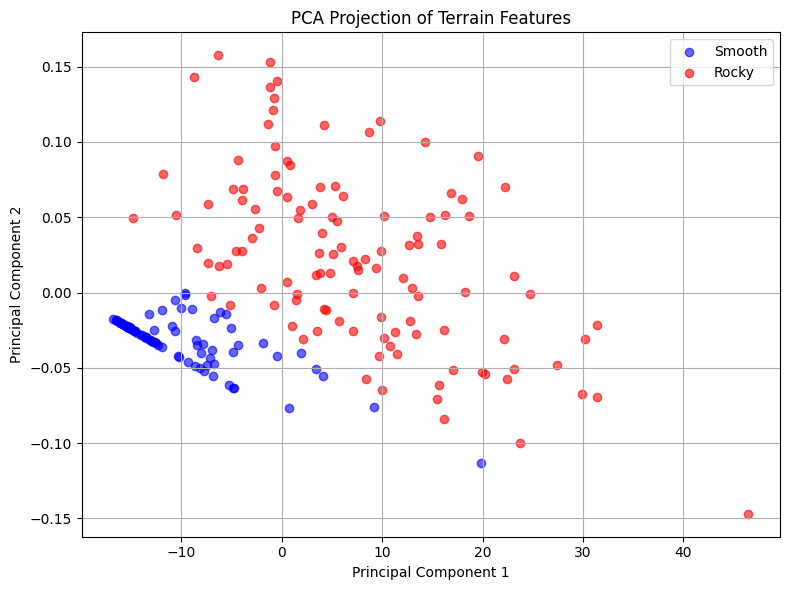

In [10]:
# Plot PCA-transformed features
plt.figure(figsize=(8, 6))

# Smooth terrain (label 0)
plt.scatter(
    X_pca[y == 0, 0],
    X_pca[y == 0, 1],
    color='blue',
    label='Smooth',
    alpha=0.6
)

# Rocky terrain (label 1)
plt.scatter(
    X_pca[y == 1, 0],
    X_pca[y == 1, 1],
    color='red',
    label='Rocky',
    alpha=0.6
)

plt.title('PCA Projection of Terrain Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Step 8: Save and Share the Notebook on Kaggle

# Step 8.1: Export Trained Model 

In [11]:
import joblib

# Save the model to a file
joblib.dump(clf, 'mars_terrain_classifier.pkl')

['mars_terrain_classifier.pkl']

<div style="background-color: #e6f7ff; padding: 15px; border-radius: 10px;">
  <h2> Project Summary: Martian Terrain Classification</h2>
  <p>
    This project uses edge detection and texture analysis (standard deviation and edge density) to classify Martian terrain patches into 
    <strong>rocky</strong> or <strong>smooth</strong> categories using NASA’s Curiosity rover image dataset.
  </p>
  <p><strong>We:</strong></p>
  <ul>
    <li>Loaded and preprocessed NAVCAM images</li>
    <li>Extracted meaningful features</li>
    <li>Visualized data using PCA</li>
    <li>Trained a Random Forest classifier</li>
    <li>Achieved [Your Accuracy] accuracy</li>
  </ul>
  <p>
    This notebook demonstrates how classical computer vision techniques can be used to solve a real-world planetary exploration problem.
  </p>
</div>